<a href="https://colab.research.google.com/github/mjavadpur/NLP_Sarcasm_Headlines/blob/main/NLP_Sarcasm_Headlines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Workshop/NLP/Sarcasm_Headlines'
os.environ['KAGGLE_USERNAME'] = "mjavadpur" # username from the json file
os.environ['KAGGLE_KEY'] = "3e9baf1e03d7cb7e8976be19949d267a" # key from the json file

In [4]:
%cd /content/drive/MyDrive/Workshop/NLP/Sarcasm_Headlines

/content/drive/MyDrive/Workshop/NLP/Sarcasm_Headlines


In [5]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

news-headlines-dataset-for-sarcasm-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip /content/drive/MyDrive/Workshop/NLP/Sarcasm_Headlines/news-headlines-dataset-for-sarcasm-detection.zip -d /content/drive/MyDrive/Workshop/NLP/Sarcasm_Headlines

Archive:  /content/drive/MyDrive/Workshop/NLP/Sarcasm_Headlines/news-headlines-dataset-for-sarcasm-detection.zip
replace /content/drive/MyDrive/Workshop/NLP/Sarcasm_Headlines/Sarcasm_Headlines_Dataset.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/Workshop/NLP/Sarcasm_Headlines/Sarcasm_Headlines_Dataset_v2.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# About Dataset
## News Headlines Dataset For Sarcasm Detection
URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection?datasetId=30764

Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.

This new dataset has following advantages over the existing Twitter datasets:

* Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.

* Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

* Unlike tweets which are replies to other tweets, the news headlines we obtained are self-contained. This would help us in teasing apart the real sarcastic elements.

## **Columns**
Each record consists of three attributes:

* is_sarcastic: 1 if the record is sarcastic otherwise 0

* headline: the headline of the news article

* article_link: link to the original news article. Useful in collecting supplementary data

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
%cd /content/drive/MyDrive/Workshop/NLP/Sarcasm_Headlines


/content/drive/MyDrive/Workshop/NLP/Sarcasm_Headlines


In [9]:
DATA_SET = pd.read_json("/content/drive/MyDrive/Workshop/NLP/Sarcasm_Headlines/Sarcasm_Headlines_Dataset_v2.json", lines=True)
DATA_SET.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [10]:
DATA_SET.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [11]:
DATA_SET['is_sarcastic'].unique()

array([1, 0])

<Axes: xlabel='is_sarcastic', ylabel='count'>

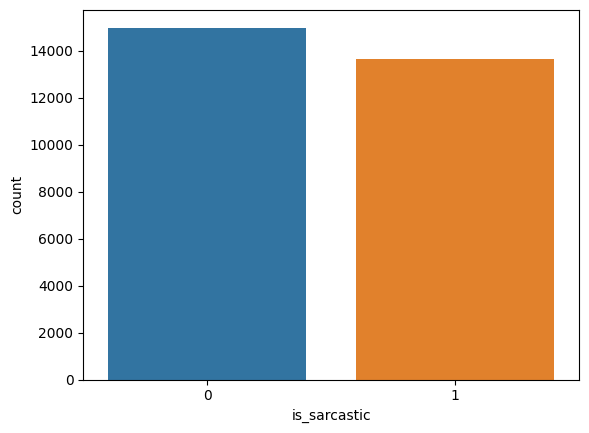

In [12]:
sns.countplot(x = 'is_sarcastic', data=DATA_SET )


In [13]:
DATA_SET.isna().sum() # Checking for nan Values


is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [14]:
print("Data Distribution: \n -------------------------- \n")
print(DATA_SET.is_sarcastic.value_counts()/len(DATA_SET))

print("\nData Count: \n -------------------------- \n")
print(DATA_SET.is_sarcastic.value_counts())



Data Distribution: 
 -------------------------- 

0    0.523603
1    0.476397
Name: is_sarcastic, dtype: float64

Data Count: 
 -------------------------- 

0    14985
1    13634
Name: is_sarcastic, dtype: int64


In [15]:
df = DATA_SET.copy()

**WHAT ARE STOPWORDS?**

Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.

In [16]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

## **DATA CLEANING**

In [17]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_URLS(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_URLS(text)
    text = text.lower()
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

<ipython-input-17-475ae3f9a3a6>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


* WORDCLOUD FOR REAL headline (is_sarcastic = 1)

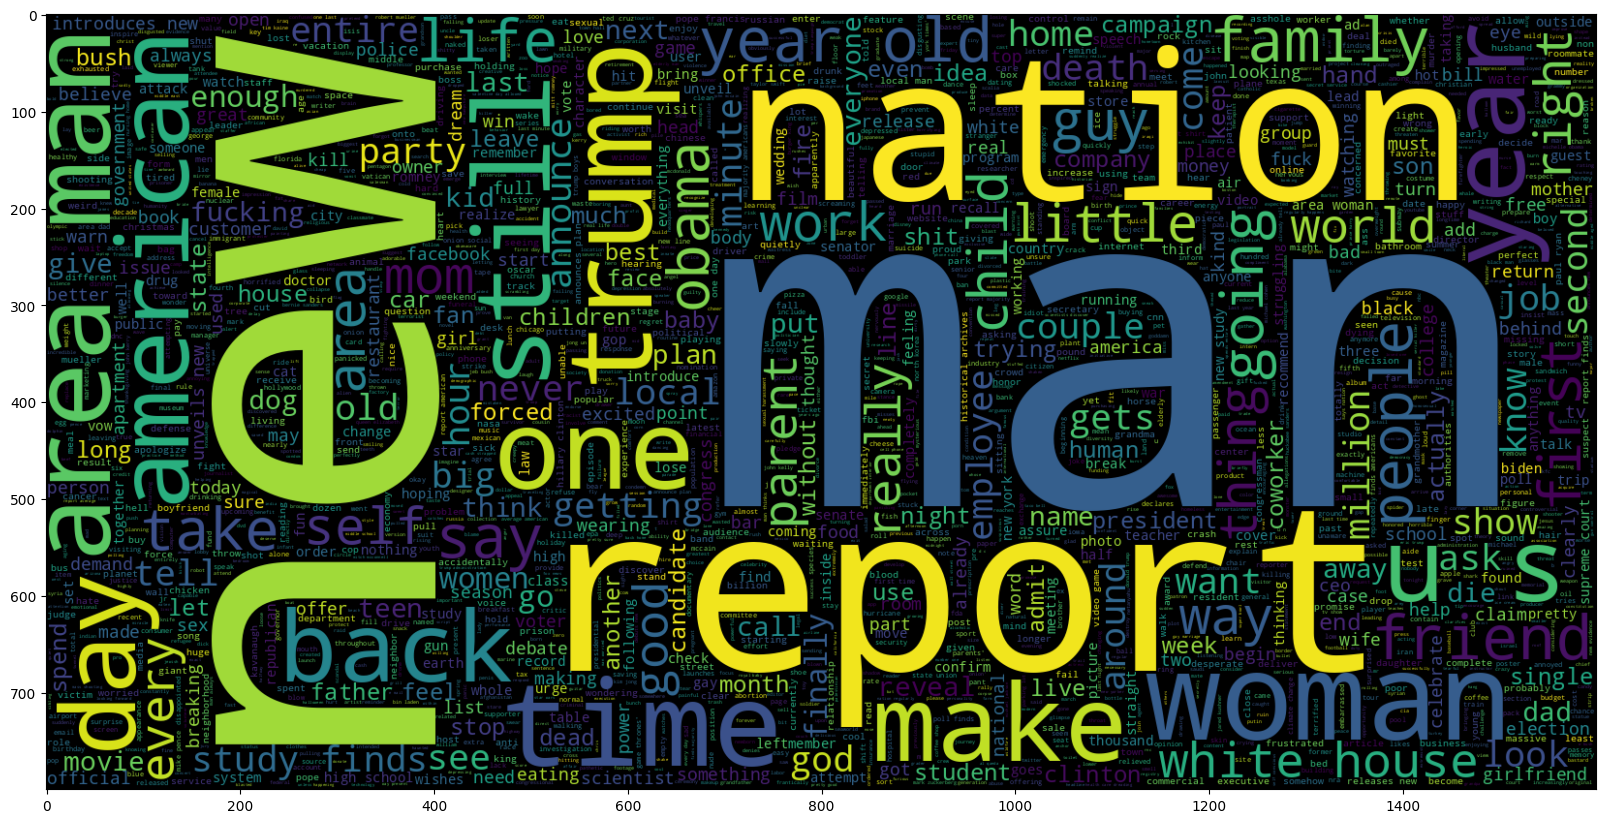

In [18]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

* WORDCLOUD FOR REAL headline (is_sarcastic = 0)

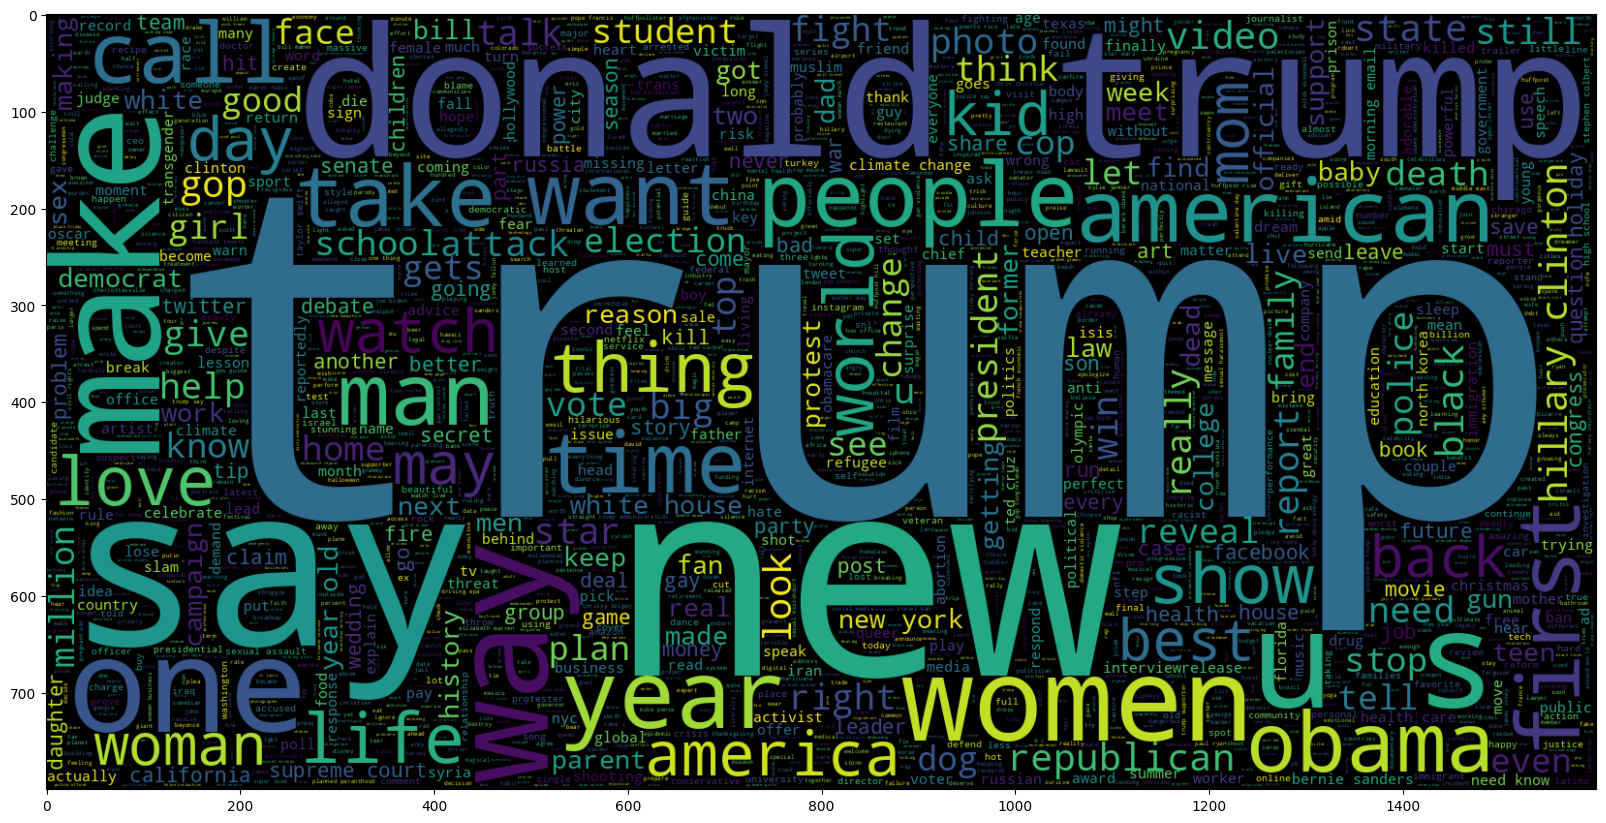

In [19]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

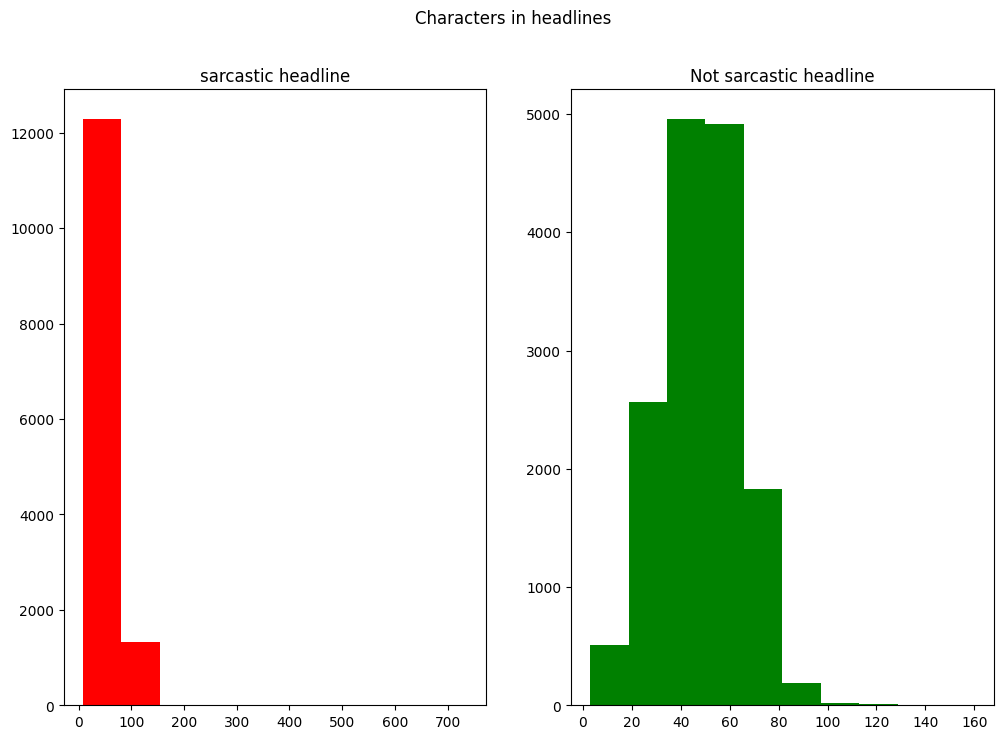

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('sarcastic headline')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not sarcastic headline')
fig.suptitle('Characters in headlines')
plt.show()

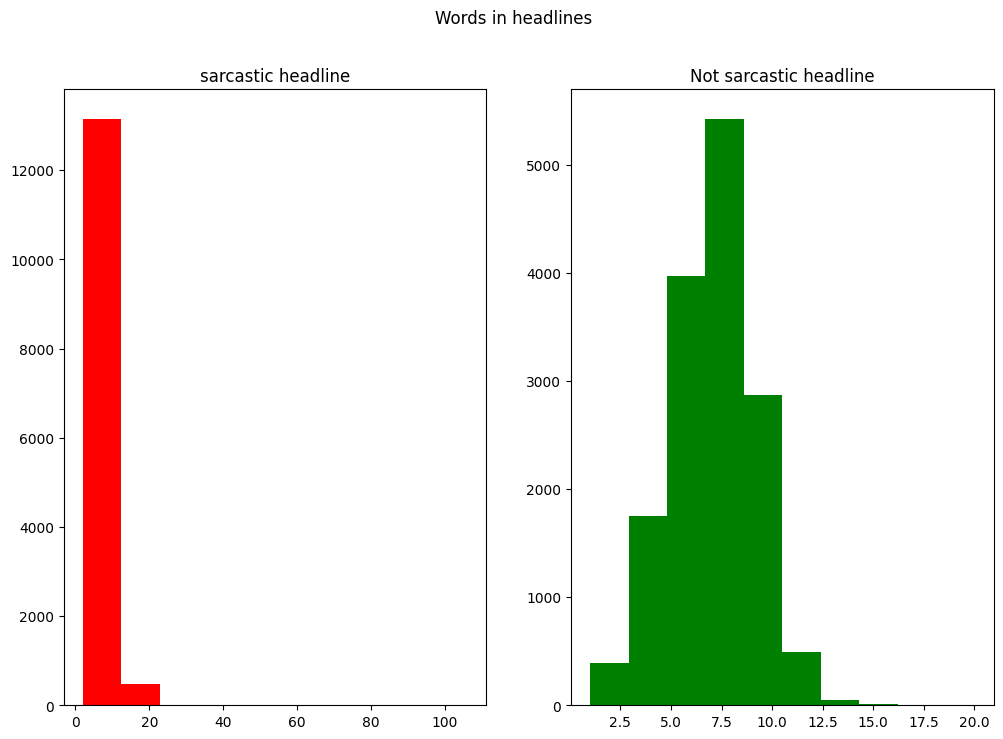

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('sarcastic headline')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not sarcastic headline')
fig.suptitle('Words in headlines')
plt.show()

<ipython-input-22-9896b947c41d>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
<ipython-input-22-9896b947c41d>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')


Text(0.5, 0.98, 'Average word length in each headline')

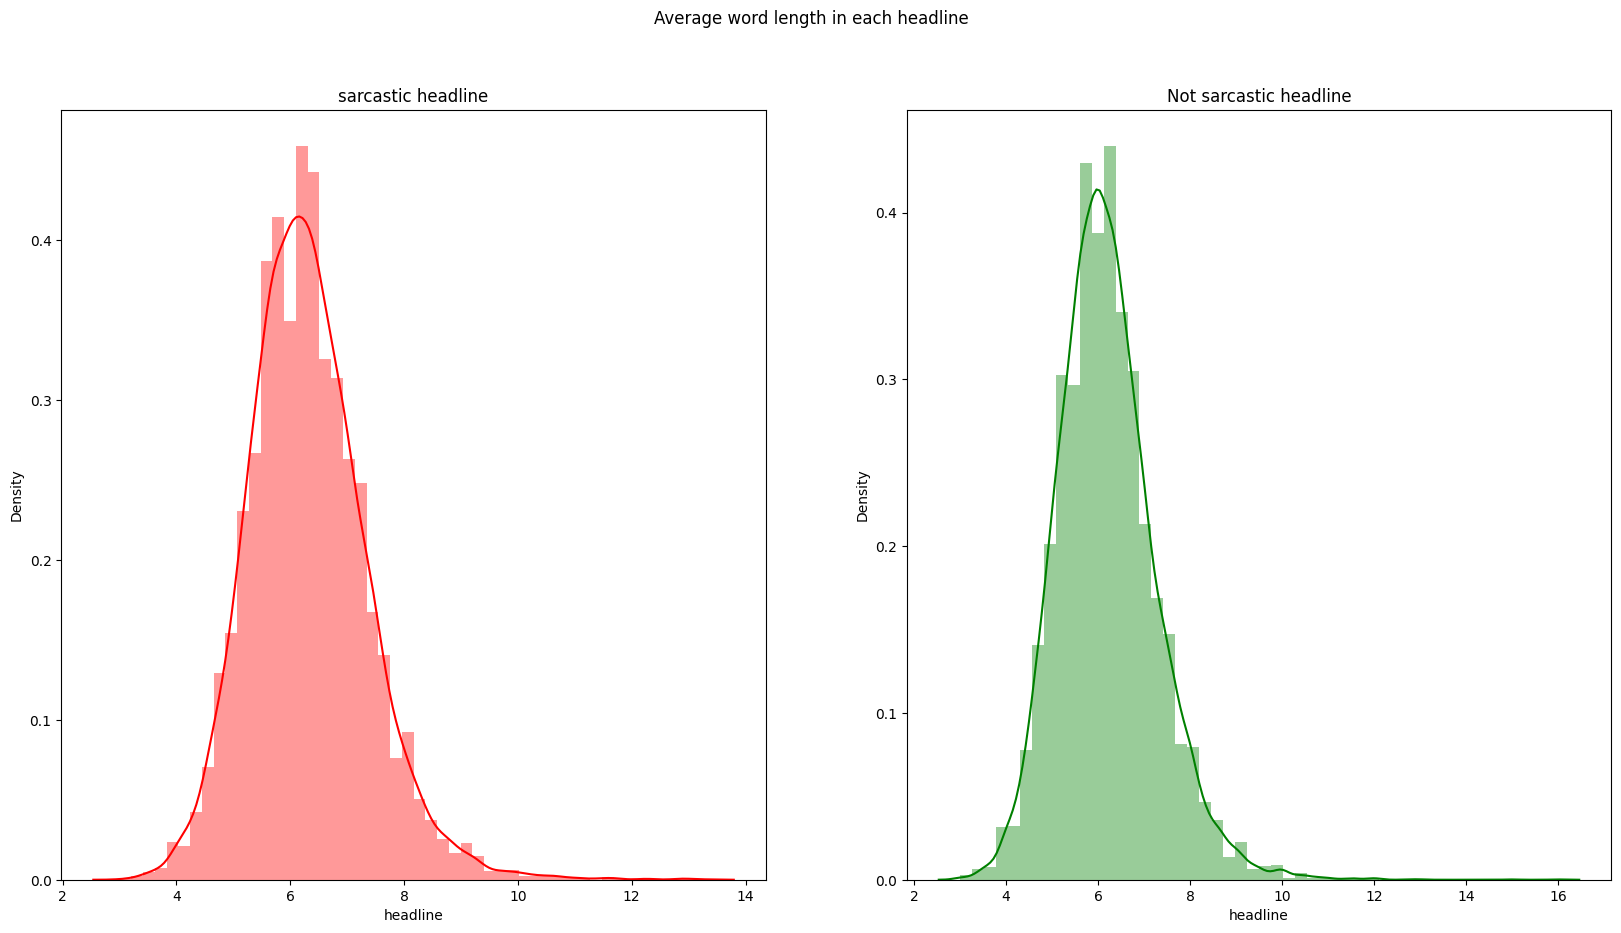

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('sarcastic headline')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not sarcastic headline')
fig.suptitle('Average word length in each headline')

In [23]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.headline)
corpus[:5]

['thirtysomething', 'scientists', 'unveil', 'doomsday', 'clock']

In [24]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'new': 1637,
 'man': 1351,
 'trump': 1284,
 'one': 527,
 'area': 494,
 'woman': 483,
 'says': 482,
 'donald': 472,
 'report:': 452,
 'u.s.': 441}

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

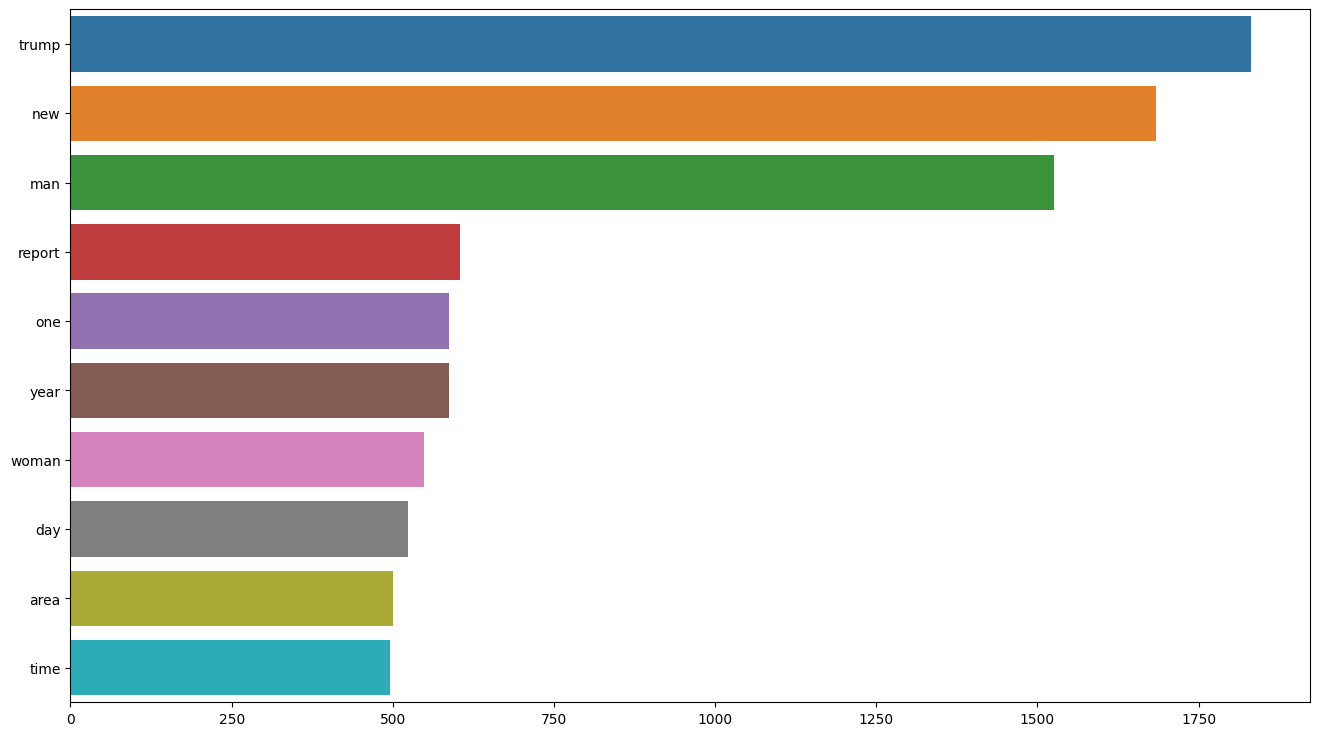

In [26]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.headline,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

<Axes: >

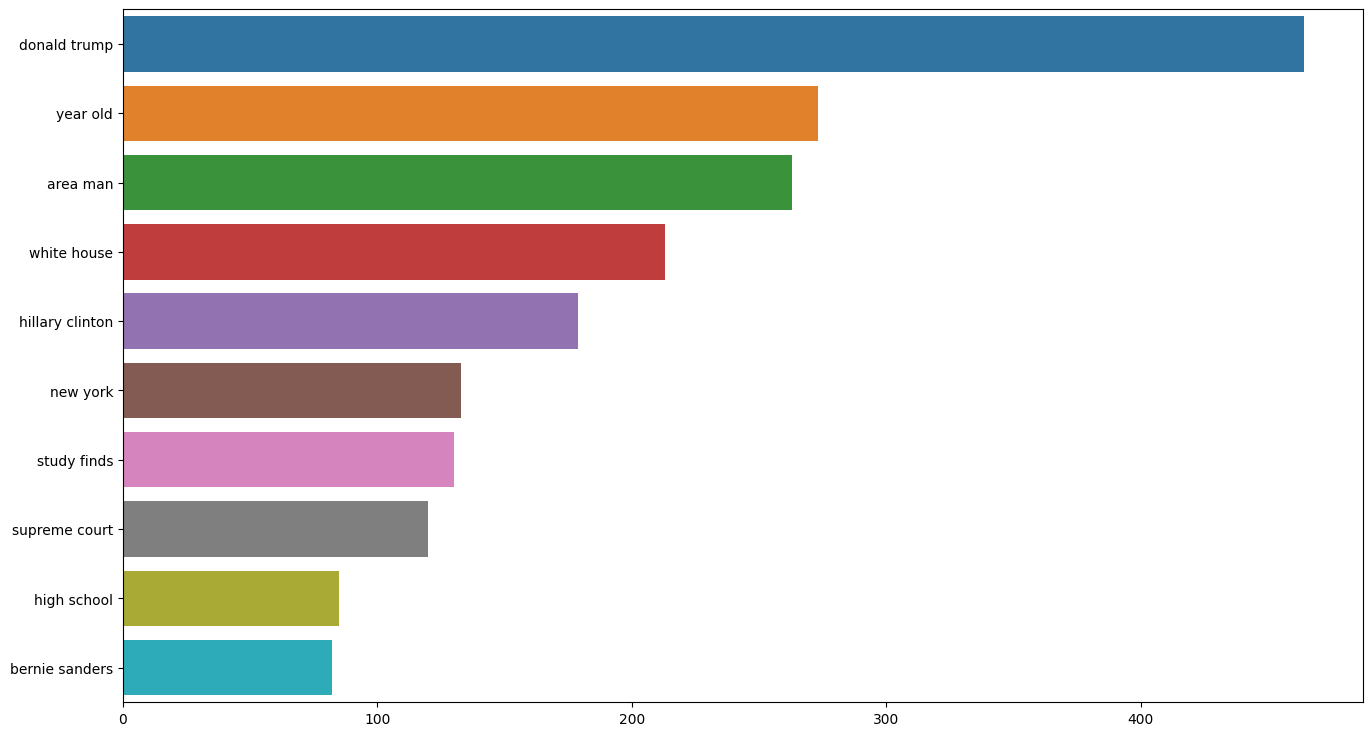

In [27]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.headline,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

<Axes: >

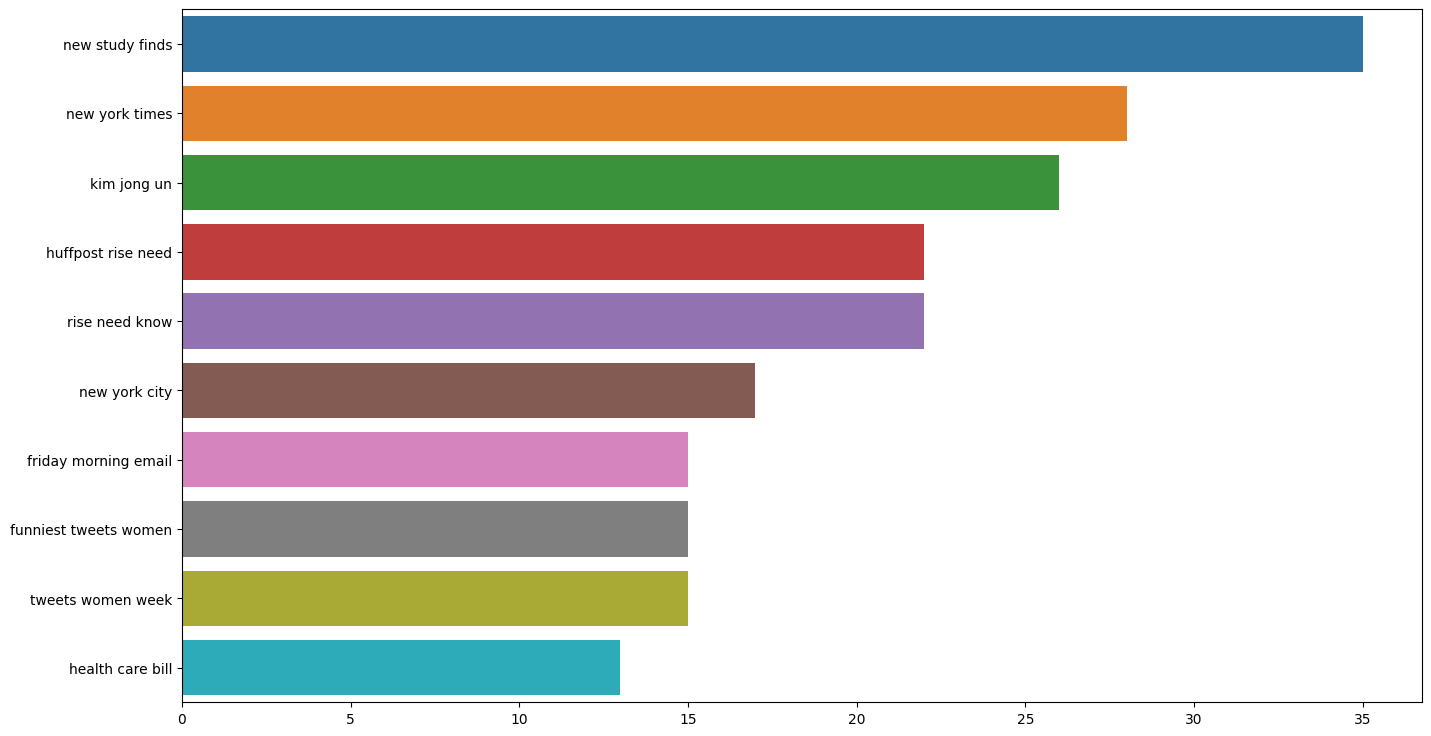

In [28]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.headline,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

# **Deep Learning**

## Splitting the data into 2 parts - training and testing data

In [29]:
x_train,x_test,y_train,y_test = train_test_split(df.headline,df.is_sarcastic,random_state = 0)

In [30]:
max_features = 10000
maxlen = 300

Tokenizing Headline -> Repsesenting each word by a number

Mapping of orginal word to number is preserved in word_index property of tokenizer

Tokenized applies basic processing like changing it to lower case, explicitely setting that as False

Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones

In [31]:
# padded_train = pad_sequences(train_sequences,maxlen = 42, padding = 'post', truncating = 'post')

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(tokenized_train, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

# Introduction to GloVe
**GloVe method is built on an important idea,
You can derive semantic relationships between words from the co-occurrence matrix.
Given a corpus having V words, the co-occurrence matrix X will be a V x V matrix, where the i th row and j th column of X, X_ij denotes how many times word i has co-occurred with word j. An example co-occurrence matrix might look as follows.**


**The co-occurrence matrix for the sentence “the cat sat on the mat” with a window size of 1. As you probably noticed it is a symmetric matrix.
How do we get a metric that measures semantic similarity between words from this? For that, you will need three words at a time. Let me concretely lay down this statement.**

In [32]:
!kaggle datasets download -d bertcarremans/glovetwitter27b100dtxt

glovetwitter27b100dtxt.zip: Skipping, found more recently modified local copy (use --force to force download)


In [33]:
!unzip /content/drive/MyDrive/Workshop/NLP/Sarcasm_Headlines/glovetwitter27b100dtxt.zip -d /content/drive/MyDrive/Workshop/NLP/Sarcasm_Headlines

Archive:  /content/drive/MyDrive/Workshop/NLP/Sarcasm_Headlines/glovetwitter27b100dtxt.zip
replace /content/drive/MyDrive/Workshop/NLP/Sarcasm_Headlines/glove.twitter.27B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [34]:
EMBEDDING_FILE = '/content/drive/MyDrive/Workshop/NLP/Sarcasm_Headlines/glove.twitter.27B.100d.txt'


In [35]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [36]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [37]:
batch_size = 256
epochs = 10
embed_size = 100

In [38]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

# TRAINING THE MODEL

In [39]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [41]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
84/84 [==============================] - 228s 3s/step - loss: 0.5984 - accuracy: 0.6692 - val_loss: 0.5142 - val_accuracy: 0.7500 - lr: 0.0100
Epoch 2/10
84/84 [==============================] - 213s 3s/step - loss: 0.4857 - accuracy: 0.7656 - val_loss: 0.4549 - val_accuracy: 0.7880 - lr: 0.0100
Epoch 3/10
84/84 [==============================] - 220s 3s/step - loss: 0.4420 - accuracy: 0.7924 - val_loss: 0.4349 - val_accuracy: 0.7975 - lr: 0.0100
Epoch 4/10
84/84 [==============================] - 218s 3s/step - loss: 0.4053 - accuracy: 0.8152 - val_loss: 0.4286 - val_accuracy: 0.7994 - lr: 0.0100
Epoch 5/10
84/84 [==============================] - 215s 3s/step - loss: 0.3771 - accuracy: 0.8259 - val_loss: 0.4458 - val_accuracy: 0.7932 - lr: 0.0100
Epoch 6/10
84/84 [==============================] - 217s 3s/step - loss: 0.3507 - accuracy: 0.8446 - val_loss: 0.4112 - val_accuracy: 0.8110 - lr: 0.0100
Epoch 7/10
84/84 [==============================] - 219s 3s/step - loss: 0.3

# ANALYSIS AFTER TRAINING OF MODEL

In [42]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

671/671 [==============================] - 110s 164ms/step - loss: 0.1671 - accuracy: 0.9400
Accuracy of the model on Training Data is -  93.99925470352173 %
224/224 [==============================] - 37s 166ms/step - loss: 0.4248 - accuracy: 0.8161
Accuracy of the model on Testing Data is -  81.60727024078369 %


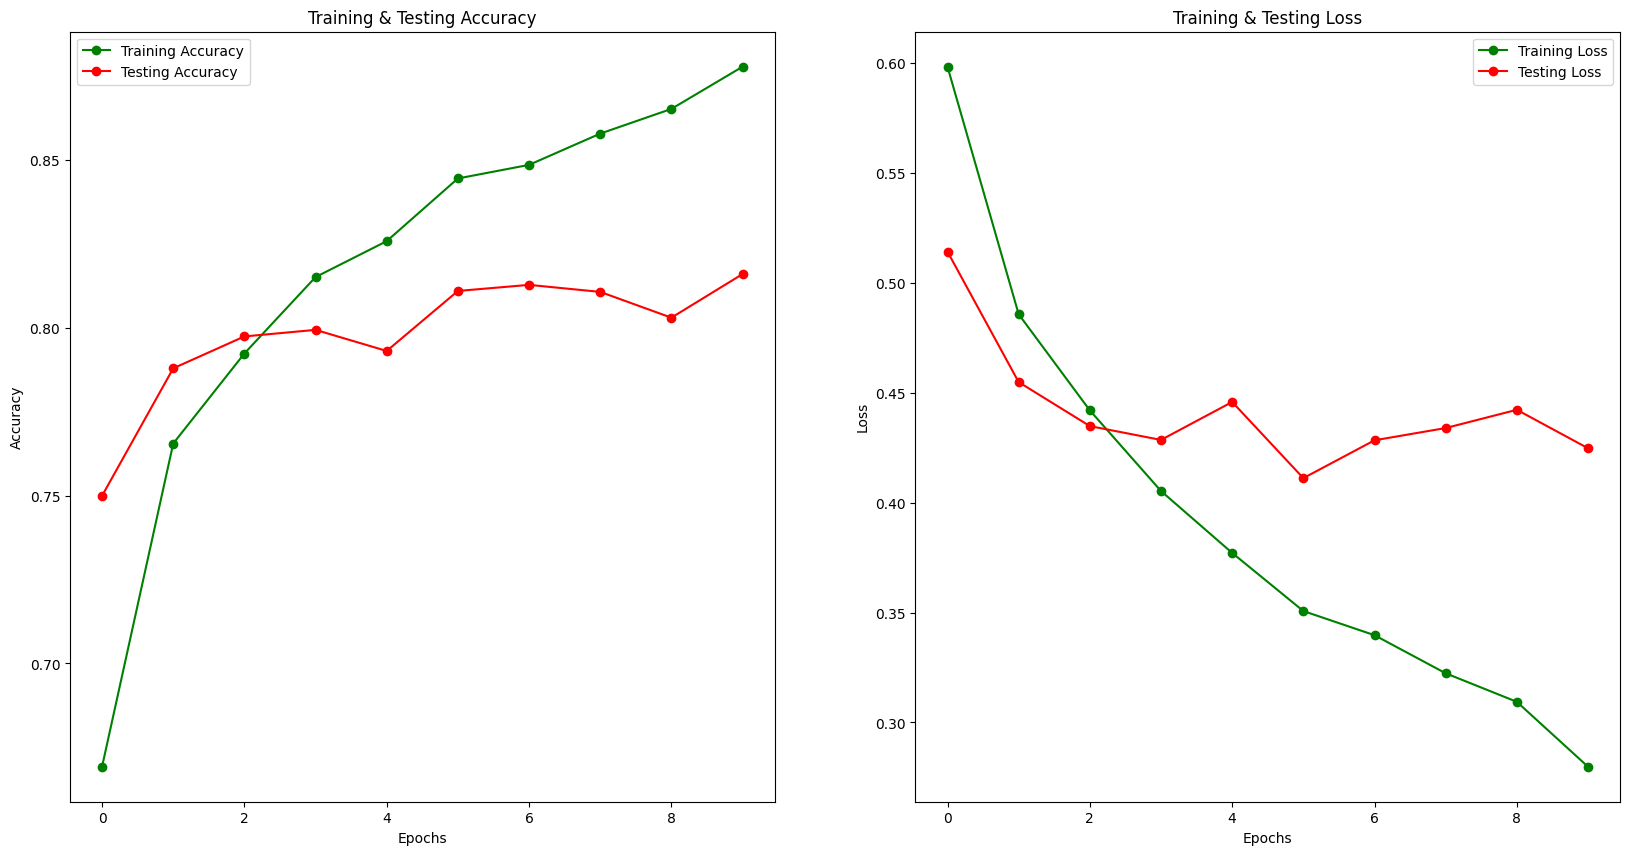

In [43]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()